# Initialization

In [617]:
import numpy as np

SEED = 42
NUM_ELEMENTS = 100000
NUM_UNIQUE = 10000
NUM_RUNS = 25

# Set the seed for reproducibility
np.random.seed(SEED)
stream = np.random.randint(0, NUM_UNIQUE, NUM_ELEMENTS)

print(f"Stream length: {len(stream)}")
print(f"Number of unique elements: {len(np.unique(stream))}")
print(f"First 10 elements of the stream: {stream[:10]}")

Stream length: 100000
Number of unique elements: 10000
First 10 elements of the stream: [7270  860 5390 5191 5734 6265  466 4426 5578 8322]


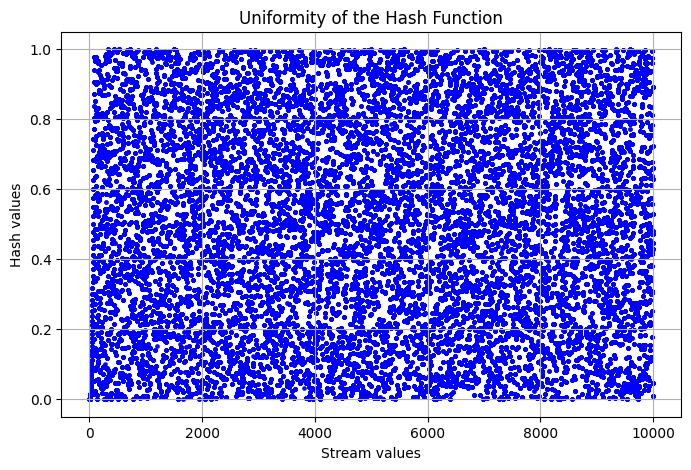

In [641]:
import matplotlib.pyplot as plt

# Prime number for the hash function, P > NUM_UNIQUE
P = 2**19 - 1

def hash_stream(stream: np.ndarray, a: int, b: int, m: int = P, normalize: bool = True, p: int = P) -> np.ndarray:
    """
    Hash the stream using the hash function (a * stream + b)^3 % p % m.
    :param stream: The stream to hash
    :param a: The slope of the hash function
    :param b: The intercept of the hash function
    :param p: The prime number for the hash function
    :param m: The range of the hash function
    :param normalize: Whether to normalize the hash values to [0, 1) or not
    :return: The hashed stream
    """
    return ((((a if a > 0 else 1) * stream + b)**3 % p) % m) / (m if normalize else 1)

# Plot the uniformity of the hash function
plt.figure(figsize=(8, 5))
plt.scatter(stream, hash_stream(stream, 1, 2), alpha=0.7, color='blue', s=5)
plt.title("Uniformity of the Hash Function")
plt.xlabel("Stream values")
plt.ylabel("Hash values")
plt.grid(True)
plt.show()

## Flajolet Martin

### Flajolet Martin - Alpha Version

In [642]:
def flajolet_martin(stream: np.ndarray, seed: int = SEED) -> float:
    """
    Flajolet-Martin algorithm for counting distinct elements in a stream.
    :param stream: numpy array of elements
    :param seed: seed for the random number generator
    :return: estimated number of distinct elements
    """
    a, b = np.random.default_rng(seed).integers(0, P, size=2)
    hashed_stream = hash_stream(stream, a, b)
    return 1 / np.min(hashed_stream)

### Flajolet Martin - Beta Version

In [643]:
def flajolet_martin_beta(stream: np.ndarray, s: int, seed: int = SEED) -> float:
    """
    Flajolet-Martin Beta algorithm for counting distinct elements in a stream.
    :param stream: numpy array of elements
    :param s: number of FM estimators to calculate
    :param seed: seed for the random number generator
    :return: estimated number of distinct elements
    """
    hash_funcs = np.random.default_rng(seed).integers(0, P, size=(s, 2))
    estimates = np.array([hash_stream(stream, a, b) for a, b in hash_funcs])    
    Z = np.min(estimates, axis=1)
    return 1 / np.mean(Z) - 1

Sketch sizes: [1, 2, 4, 8, 16, 32, 64]


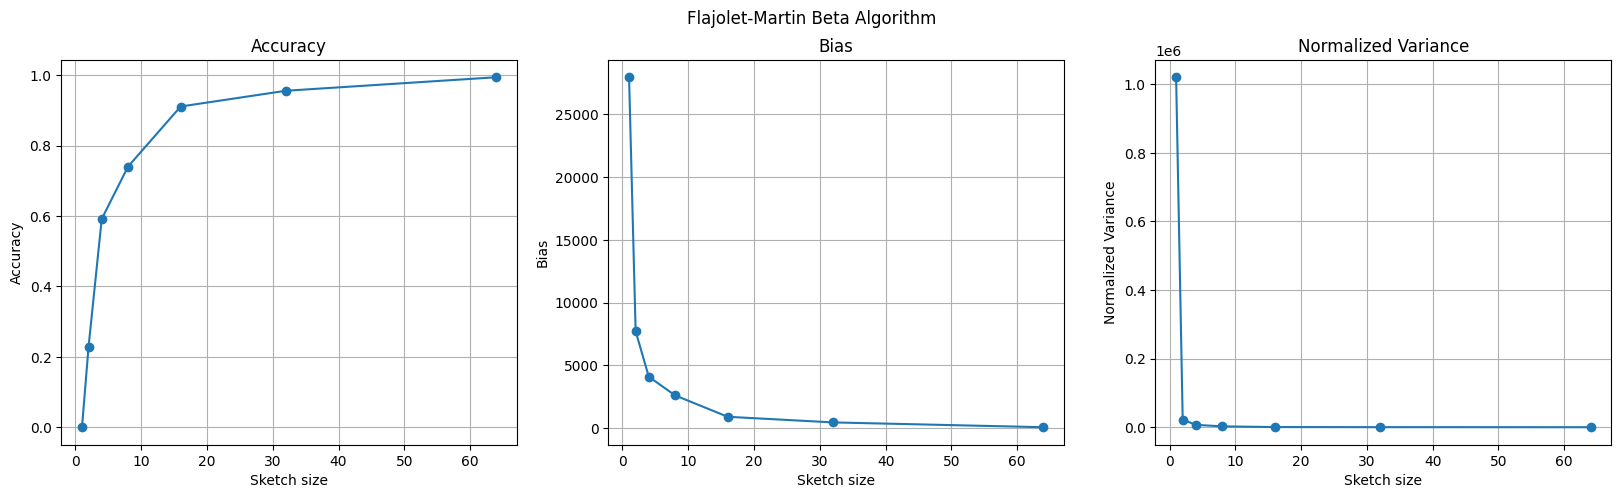

In [666]:
import matplotlib.pyplot as plt

S = [1, 2, 4, 8, 16, 32, 64]
print(f"Sketch sizes: {S}")

results = {s: [flajolet_martin_beta(stream, s, i) for i in range(NUM_RUNS)] for s in S}

def plot_metrics(results: dict, title: str):
    """
    Plot the results of the Flajolet-Martin Beta algorithm.
    :param results: Dictionary with the results
    :param title: Title of the plot
    """
    sketch_sizes = list(results.keys())
    metrics = {}
    for s, ests in results.items():
        mean = np.mean(ests)
        accuracy = max(0, 1 - np.abs(mean - NUM_UNIQUE) / NUM_UNIQUE)
        bias = mean - NUM_UNIQUE
        normalized_variance = np.var(ests) / NUM_UNIQUE
        metrics[s] = {
            "accuracy": accuracy,
            "bias": bias,
            "normalized_variance": normalized_variance
        }

    plt.figure(figsize=(20, 5))
    plt.suptitle(title)

    plt.subplot(1, 3, 1)
    plt.plot(sketch_sizes, [metrics[s]["accuracy"] for s in sketch_sizes], marker='o')
    plt.title("Accuracy")
    plt.xlabel("Sketch size")
    plt.ylabel("Accuracy")
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(sketch_sizes, [metrics[s]["bias"] for s in sketch_sizes], marker='o')
    plt.title("Bias")
    plt.xlabel("Sketch size")
    plt.ylabel("Bias")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(sketch_sizes, [metrics[s]["normalized_variance"] for s in sketch_sizes], marker='o')
    plt.title("Normalized Variance")
    plt.xlabel("Sketch size")
    plt.ylabel("Normalized Variance")
    plt.grid(True)

    plt.show()

plot_metrics(results, "Flajolet-Martin Beta Algorithm")

### Flajolet Martin - Final Version

In [674]:
def flajolet_martin_final(stream: np.ndarray, t: int, s: int, seed: int = SEED) -> float:
    """
    Flajolet-Martin Final algorithm that uses t instances of Flajolet-Martin Beta.
    :param stream: numpy array of elements
    :param t: number of Flajolet-Martin Beta instances to run
    :param s: number of FM estimators per Flajolet-Martin Beta instance
    :param seed: seed for the random number generator
    :return: median of the distinct element estimates
    """
    hash_funcs = np.random.default_rng(seed).integers(0, P, size=(t, s, 2))
    
    Zs = [np.min([hash_stream(stream, a, b) for a, b in hash_funcs[i]], axis=1) for i in range(t)]
    estimates = [1 / np.mean(Z) - 1 for Z in Zs]
        
    return np.median(estimates)

Sketch sizes: ['1 x 1 = 1', '1 x 5 = 5', '1 x 10 = 10', '5 x 5 = 25', '5 x 10 = 50', '10 x 10 = 100']


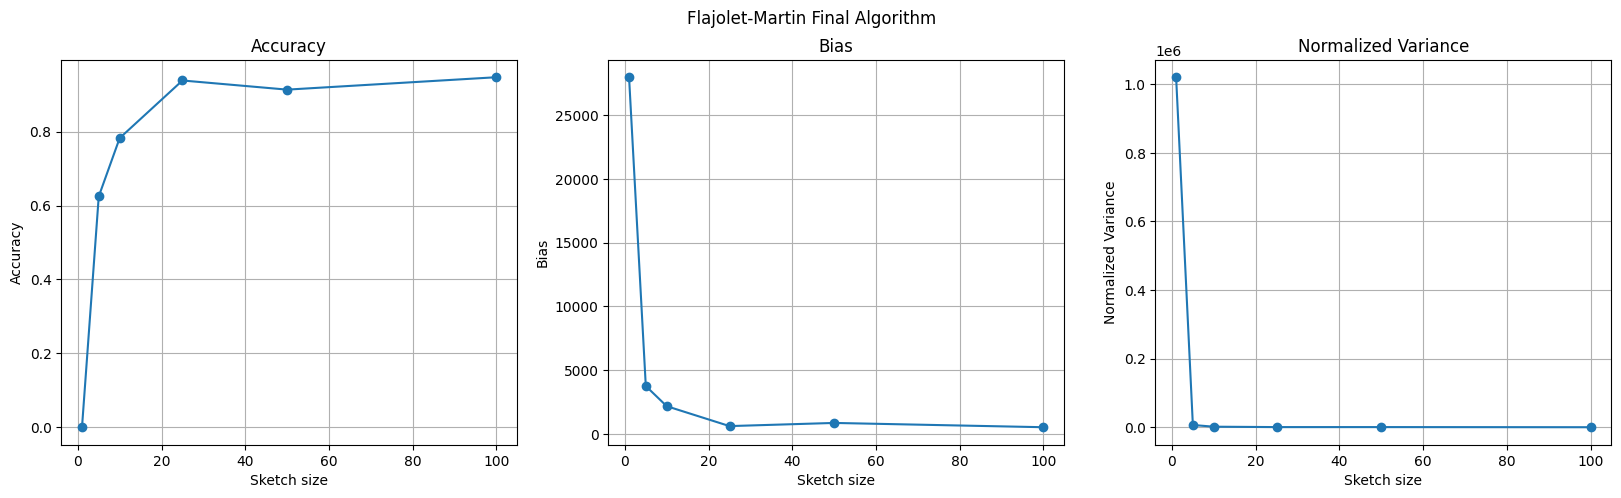

In [680]:
TS = [(1, 1), (1, 5), (1, 10), (5, 5), (5, 10), (10, 10)]
print(f"Sketch sizes: {[f'{t} x {s} = {t * s}' for t, s in TS]}")

results = {t * s: [flajolet_martin_final(stream, t, s, i) for i in range(NUM_RUNS)] for t, s in TS}

plot_metrics(results, "Flajolet-Martin Final Algorithm")

Run 25 times for each sketch size

In [590]:
delta = 0.05  # 95% confidence interval
delta_beta = 1/3

epsilon = np.sqrt(np.log(1 / delta) / len(stream))  # Maintain space complexity of O(log(1/delta)/epsilon^2)
print(f"Maintain space complexity of O(log(1/delta)/epsilon^2): epsilon = {epsilon:.2f}")
print(f"With delta = {delta}, the 95% confidence interval is satisfied.")
print(f"Goal: Pr[|Z - Z^| / Z < {epsilon:.2f}] > 0.95.") 

t = int(np.ceil(np.log(1 / delta)))  # Number of Flajolet-Martin Beta instances
print(f"Number of Flajolet-Martin Beta instances = O(log(1/delta)): t = {t}")
s = int(np.ceil(np.log(1 / (delta_beta * epsilon**2))))  # Number of FM estimators per Flajolet-Martin Beta instance
print(f"Number of FM estimators per Flajolet-Martin Beta instance = O(log(1/(delta_beta * epsilon^2))): s = {s}")

print("Running Flajolet-Martin Final algorithm...")
estimates = [flajolet_martin_final(stream, t, s) for _ in range(NUM_RUNS)]

print(f"Estimated number of unique elements: {np.mean(estimates):.2f}")
print(f"True number of unique elements: {num_unique_elements}")
print(f"Relative error: |Z - Z^| / Z = {np.abs(num_unique_elements - np.mean(estimates)) / num_unique_elements:.2f}")
print(f"Indeed, Relative error < epsilon = {epsilon:.2f}")

Maintain space complexity of O(log(1/delta)/epsilon^2): epsilon = 0.01
With delta = 0.05, the 95% confidence interval is satisfied.
Goal: Pr[|Z - Z^| / Z < 0.01] > 0.95.
Number of Flajolet-Martin Beta instances = O(log(1/delta)): t = 3
Number of FM estimators per Flajolet-Martin Beta instance = O(log(1/(delta_beta * epsilon^2))): s = 12
Running Flajolet-Martin Final algorithm...
Estimated number of unique elements: 10484.92
True number of unique elements: 10000
Relative error: |Z - Z^| / Z = 0.05
Indeed, Relative error < epsilon = 0.01


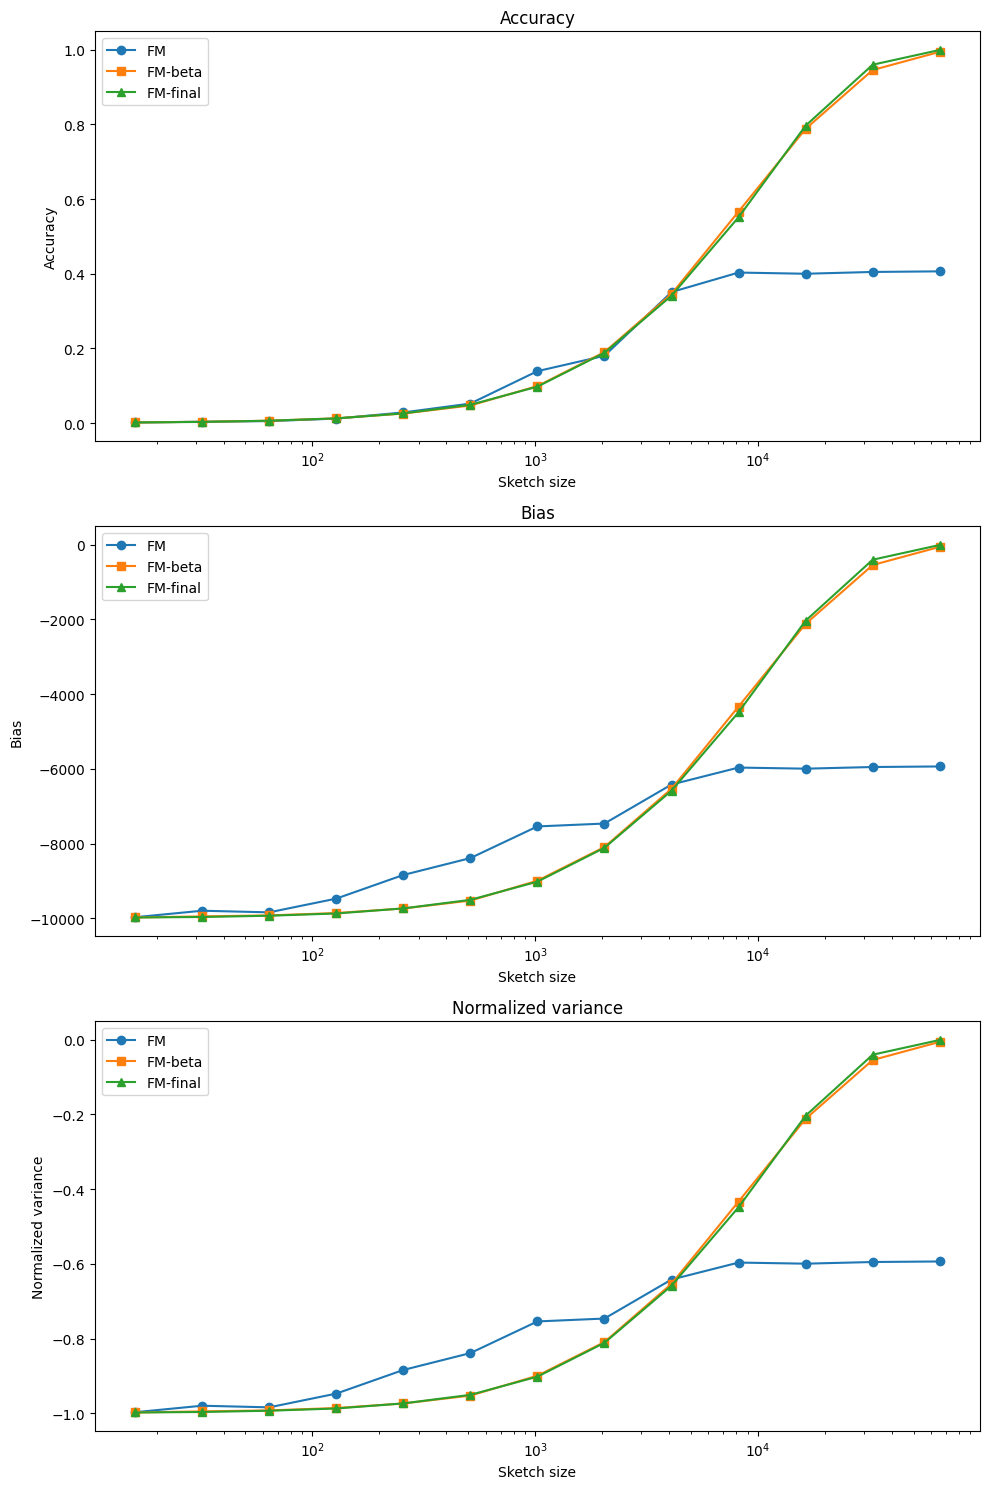

In [203]:
import scipy.stats as stats
import matplotlib.pyplot as plt

fm_results = {sketch_size: results[i][0] for i, sketch_size in enumerate(sketch_sizes)}
fm_beta_results = {sketch_size: results[i][1] for i, sketch_size in enumerate(sketch_sizes)}
fm_final_results = {sketch_size: results[i][2] for i, sketch_size in enumerate(sketch_sizes)}

def calculate_metrics(estimates: dict) -> dict:
    """
    Calculate the accuracy, bias, and normalized variance of the estimates.
    :param estimates: dictionary of estimates
    :return: dictionary of metrics
    """
    metrics = {}
    for sketch_size, size_estimates in estimates.items():
        metrics[sketch_size] = {
            "accuracy": stats.hmean([max(0, 1 - abs(est - num_unique_elements) / num_unique_elements) for est in size_estimates]),
            "bias": np.mean([est - num_unique_elements for est in size_estimates]),
            "normalized_variance": np.mean([((est - num_unique_elements) / num_unique_elements) for est in size_estimates])
        }
    return metrics

fm_metrics = calculate_metrics(fm_results)
fm_beta_metrics = calculate_metrics(fm_beta_results)
fm_final_metrics = calculate_metrics(fm_final_results)

# Create a figure and axis
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Plot the accuracy
ax[0].plot(sketch_sizes, [fm_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM", marker='o')
ax[0].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM-beta", marker='s')
ax[0].plot(sketch_sizes, [fm_final_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM-final", marker='^')
ax[0].set_xscale("log")
ax[0].set_xlabel("Sketch size")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy")
ax[0].legend()

# Plot the bias
ax[1].plot(sketch_sizes, [fm_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM", marker='o')
ax[1].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM-beta", marker='s')
ax[1].plot(sketch_sizes, [fm_final_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM-final", marker='^')
ax[1].set_xscale("log")
ax[1].set_xlabel("Sketch size")
ax[1].set_ylabel("Bias")
ax[1].set_title("Bias")
ax[1].legend()

# Plot the normalized variance
ax[2].plot(sketch_sizes, [fm_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM", marker='o')
ax[2].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM-beta", marker='s')
ax[2].plot(sketch_sizes, [fm_final_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM-final", marker='^')
ax[2].set_xscale("log")
ax[2].set_xlabel("Sketch size")
ax[2].set_ylabel("Normalized variance")
ax[2].set_title("Normalized variance")
ax[2].legend()

plt.tight_layout()
plt.show()

## Count-Min Sketch

In [ ]:
def count_min_sketch(stream: np.ndarray, d: int, w: int) -> dict:
    """
    Count-Min Sketch algorithm for counting the frequency of elements in a stream.
    :param stream: array of elements
    :param d: depth of the sketch (number of hash functions)
    :param w: width of the sketch
    :return: dictionary of frequencies for each element in the stream, according to the sketch
    """
    # Initialize the sketch
    sketch = np.zeros((d, w), dtype=np.int32)
    
    hash_funcs = np.random.default_rng(SEED).integers(0, w, size=(d, 2))    
    indices = np.array([[int(val) for val in hash_stream(stream, a, b, w, normalize=False)] for a, b in hash_funcs]).T
    
    # Update the sketch with the stream elements according to the hashed indices
    for i, element in enumerate(stream):
        for j in range(d):
            sketch[j, indices[i, j]] += 1
                
    # Return frequencies for each element in the stream
    freqs = {element: np.min([sketch[j, indices[i, j]] for j in range(d)]) for i, element in enumerate(stream)}
        
    return freqs

# Sanity check
print(f"Real frequency of 100: {np.sum(stream == 100)}")
print(f"Estimated frequency of 100: {count_min_sketch(stream, 5, 5000)[100]}")

Real frequency of 100: 14
Estimated frequency of 100: 14


In [535]:
delta = 0.05  # 95% confidence interval
F_1 = len(stream)

def process_sketch(sketch_size: int) -> list:
    """
    Process a single sketch size.
    :param sketch_size: size of the sketch
    :return: list of frequency dictionaries
    """
    # Maintain O(log(F_1) * log(1 / delta) / epsilon) space complexity to ensure 95% success probability
    epsilon = int(np.ceil(np.log(F_1) * np.log(1 / delta) / sketch_size))
    
    print("=====================================")
    print(f"Sketch size: {sketch_size}")
    print(f"Relative error (epsilon) that guarantees 95% success probability: {epsilon:.2f}") 
    
    d = int(np.ceil(np.log(1 / delta)))
    w = int(np.ceil(2 / epsilon))
    print(f"Depth (d): {d}, Width (w): {w}")

    # Generate random indices for the stream
    indices = [np.random.choice(len(stream), size=sketch_size, replace=False) for _ in range(NUM_RUNS)]
    
    # Process the runs
    freqs_list = [count_min_sketch(stream[index], d, w) for index in indices]    
    return freqs_list

results = [process_sketch(sketch_size) for sketch_size in sketch_sizes]

Sketch size: 1
Relative error (epsilon) that guarantees 95% success probability: 35.00
Depth (d): 3, Width (w): 1
Sketch size: 2
Relative error (epsilon) that guarantees 95% success probability: 18.00
Depth (d): 3, Width (w): 1
Sketch size: 4
Relative error (epsilon) that guarantees 95% success probability: 9.00
Depth (d): 3, Width (w): 1
Sketch size: 8
Relative error (epsilon) that guarantees 95% success probability: 5.00
Depth (d): 3, Width (w): 1
Sketch size: 16
Relative error (epsilon) that guarantees 95% success probability: 3.00
Depth (d): 3, Width (w): 1
Sketch size: 32
Relative error (epsilon) that guarantees 95% success probability: 2.00
Depth (d): 3, Width (w): 1
Sketch size: 64
Relative error (epsilon) that guarantees 95% success probability: 1.00
Depth (d): 3, Width (w): 2
Sketch size: 128
Relative error (epsilon) that guarantees 95% success probability: 1.00
Depth (d): 3, Width (w): 2
Sketch size: 256
Relative error (epsilon) that guarantees 95% success probability: 1.00
D

In [536]:
import scipy.stats as stats
import matplotlib.pyplot as plt

metrics = {}
for sketch_size, freqs_list in zip(sketch_sizes, results):
    # Calculate the accuracy, bias, and normalized variance of the estimates
    accuracy = stats.hmean([max(0, 1 - abs(freqs[element] - np.sum(stream == element)) / np.sum(stream == element)) for element in stream for freqs in freqs_list])
    bias = np.mean([freqs[element] - np.sum(stream == element) for element in stream for freqs in freqs_list])
    normalized_variance = np.mean([((freqs[element] - np.sum(stream == element)) / np.sum(stream == element)) for element in stream for freqs in freqs_list])
    metrics[sketch_size] = {"accuracy": accuracy, "bias": bias, "normalized_variance": normalized_variance}

# Create a figure and axis
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Plot the accuracy
ax[0].plot(sketch_sizes, [fm_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM", marker='o')
ax[0].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM-beta", marker='s')
ax[0].plot(sketch_sizes, [fm_final_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM-final", marker='^')
ax[0].set_xscale("log")
ax[0].set_xlabel("Sketch size")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy")
ax[0].legend()

# Plot the bias
ax[1].plot(sketch_sizes, [fm_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM", marker='o')
ax[1].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM-beta", marker='s')
ax[1].plot(sketch_sizes, [fm_final_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM-final", marker='^')
ax[1].set_xscale("log")
ax[1].set_xlabel("Sketch size")
ax[1].set_ylabel("Bias")
ax[1].set_title("Bias")
ax[1].legend()

# Plot the normalized variance
ax[2].plot(sketch_sizes, [fm_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM", marker='o')
ax[2].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM-beta", marker='s')
ax[2].plot(sketch_sizes, [fm_final_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM-final", marker='^')
ax[2].set_xscale("log")
ax[2].set_xlabel("Sketch size")
ax[2].set_ylabel("Normalized variance")
ax[2].set_title("Normalized variance")
ax[2].legend()

plt.tight_layout()
plt.show()

KeyError: np.int32(7270)